<a href="https://colab.research.google.com/github/data-science-and-machine-learning/amazon-fine-food-reviews-support-vector-machine/blob/master/Amazon_Fine_Food_Reviews_Analysis_Support_Vector_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [0]:
from google.colab import drive
from google.colab import files
import os

!ls
drive.mount('/content/drive')
!cp drive/My\ Drive/Colab\ Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d snap/amazon-fine-food-reviews

!unzip amazon-fine-food-reviews.zip -d amazon_fine_food_reviews_data



drive  sample_data
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 99% 247M/251M [00:02<00:00, 135MB/s]
100% 251M/251M [00:02<00:00, 94.7MB/s]
Archive:  amazon-fine-food-reviews.zip
  inflating: amazon_fine_food_reviews_data/Reviews.csv  
  inflating: amazon_fine_food_reviews_data/database.sqlite  
  inflating: amazon_fine_food_reviews_data/hashes.txt  


# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm_notebook as tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon_fine_food_reviews_data/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 ORDER BY Time DESC LIMIT 150000 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data['Time'].values

Number of data points in our data (150000, 10)


array([1351209600, 1351209600, 1351209600, ..., 1329868800, 1329868800,
       1329868800])

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Deduplication of entries

filtered_data= filtered_data.sort_values(['Time'], axis=0, ascending=True, inplace=False)
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

filtered_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
149999,190263,B001ELL3FA,A96IA5ZZK8LV,"mjr ""mjr""",0,0,1,1329868800,Great seasoning,Great seasoning - full of flavor without chem...
149868,67226,B004JRXZKM,A1ZYG5DDK3DTIS,Spike,0,0,1,1329868800,"Definitely weird, but very filling and 0 calor...",There is definitely a trick to these and it to...


In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

70.34066666666666

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
#objective is to have at lesat 100000 points after preprocessing for train and test split.

print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(105511, 10)


1    87111
0    18400
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Great  seasoning - full of flavor without chemicals.  We received the product in a very timely way and are enjoying it on our food
The bag I received was about<br /><br />20% assorted mints<br />20% starlight fruit<br />20% strawberry soft center<br />10% assorted fruit soft center<br />10% cinnamon discs<br />10% root beer barrels<br />5% werther's original<br />1% jolly ranchers and misc. fruit candy<br />4% butterscotch discs<br /><br />seemed fresh, delivered on time
Zola isn't worth the taste with the current price of around 30 dollars/12. It used to be worth the taste when it was 20 dollars/12 few months ago.<br />Zola taste sweet, with sugar content 21g, with serving per container 1.5.<br />I may give few more shots on this drinks, and revise my review, if necessary, depending on how taste is compared to the price changes.
I've had these M&Ms before and they are delicious. The bag sold by this reseller however is absolutely terrible!<br /><br />When I opened the bag, much of the

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Great  seasoning - full of flavor without chemicals.  We received the product in a very timely way and are enjoying it on our food


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Great  seasoning - full of flavor without chemicals.  We received the product in a very timely way and are enjoying it on our food
The bag I received was about20% assorted mints20% starlight fruit20% strawberry soft center10% assorted fruit soft center10% cinnamon discs10% root beer barrels5% werther's original1% jolly ranchers and misc. fruit candy4% butterscotch discsseemed fresh, delivered on time
Zola isn't worth the taste with the current price of around 30 dollars/12. It used to be worth the taste when it was 20 dollars/12 few months ago.Zola taste sweet, with sugar content 21g, with serving per container 1.5.I may give few more shots on this drinks, and revise my review, if necessary, depending on how taste is compared to the price changes.
I've had these M&Ms before and they are delicious. The bag sold by this reseller however is absolutely terrible!When I opened the bag, much of the color had faded from the candies. This was the first sign that they were old or expired. I tast

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Zola is not worth the taste with the current price of around 30 dollars/12. It used to be worth the taste when it was 20 dollars/12 few months ago.<br />Zola taste sweet, with sugar content 21g, with serving per container 1.5.<br />I may give few more shots on this drinks, and revise my review, if necessary, depending on how taste is compared to the price changes.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Great  seasoning - full of flavor without chemicals.  We received the product in a very timely way and are enjoying it on our food


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Zola is not worth the taste with the current price of around 30 dollars 12 It used to be worth the taste when it was 20 dollars 12 few months ago br Zola taste sweet with sugar content 21g with serving per container 1 5 br I may give few more shots on this drinks and revise my review if necessary depending on how taste is compared to the price changes 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [0]:
preprocessed_reviews[1500]

'zola not worth taste current price around used worth taste months ago zola taste sweet sugar content serving per container may give shots drinks revise review necessary depending taste compared price changes'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(preprocessed_reviews, final['Score'], test_size= 0.20, shuffle= False, stratify= None)

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features= 500) #in scikit-learn
count_vect.fit_transform(x_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(x_train)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


final_counts_test= count_vect.transform(x_test)

some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'already', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (84408, 500)
the number of unique words  500


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features= 500)
tf_idf_vect.fit(x_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(x_train)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

final_tf_idf_test = tf_idf_vect.transform(x_test)


some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'already', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (84408, 500)
the number of unique words including both unigrams and bigrams  500


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8643803596496582), ('fantastic', 0.848368763923645), ('good', 0.83602374792099), ('terrific', 0.8232795596122742), ('wonderful', 0.8075069189071655), ('excellent', 0.7997402548789978), ('amazing', 0.7577311396598816), ('perfect', 0.7493945360183716), ('nice', 0.7151715159416199), ('fabulous', 0.711033284664154)]
[('greatest', 0.7915922403335571), ('best', 0.746336817741394), ('tastiest', 0.7182387113571167), ('awful', 0.6707941293716431), ('nastiest', 0.6600497364997864), ('disgusting', 0.6593442559242249), ('closest', 0.6588883996009827), ('smoothest', 0.6585008502006531), ('horrible', 0.6506609916687012), ('vile', 0.6475635170936584)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17609
sample words  ['great', 'seasoning', 'full', 'flavor', 'without', 'chemicals', 'received', 'product', 'timely', 'way', 'enjoying', 'food', 'definitely', 'trick', 'took', 'bit', 'could', 'really', 'figure', 'properly', 'prepare', 'come', 'package', 'strange', 'almost', 'silicone', 'smell', 'rubbery', 'texture', 'dump', 'directly', 'colander', 'run', 'hot', 'water', 'seconds', 'hands', 'let', 'dry', 'sometimes', 'even', 'blot', 'paper', 'towel', 'otherwise', 'sauce', 'slides', 'favorite', 'pasta', 'good']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))    
    
    


84408
50



21103
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features= 500)
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec


i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
    
    
    
    
i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1    

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV as RSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.utils import class_weight

cross= 2

Fitting 2 folds for each of 22 candidates, totalling 44 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    4.7s finished


best score :  0.8936902924743952
best parameter :  {'penalty': 'l2', 'alpha': 0.01}


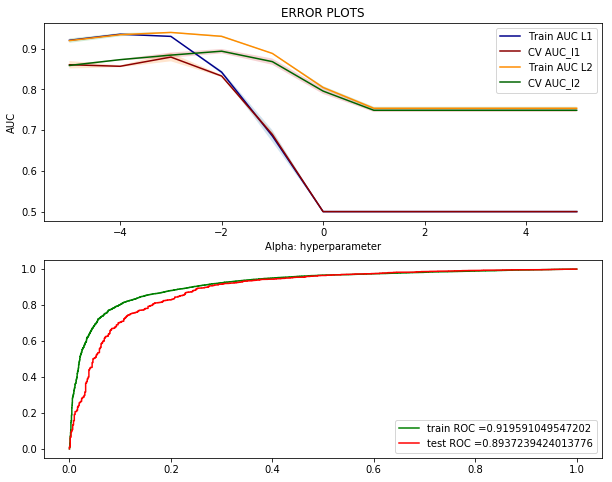

Train confusion matrix: 
[[ 2426   333]
 [ 2304 10975]]

Test confusion matrix: 
[[ 510  116]
 [ 605 2779]]

Test Sensitivity or True Positive Rate: 0.46
Test Specificity or False Negative Rate: 0.96


In [36]:
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
alpha_list = (list(np.power(([10]*len(powers)), powers)))

estimator= SGDClassifier(loss='hinge', class_weight= 'balanced')
param_distributions={
    'alpha' : alpha_list,
    'penalty' : ['l1', 'l2']
    
}

train= final_counts
test= final_counts_test
rand= RSearchCV(estimator, param_distributions, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cross, verbose=2, random_state=5, return_train_score=True)
grid= rand.fit(train, y_train)
best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_
#print(rand.cv_results_[] )
print('best score : ', best_score)
print('best parameter : ', best_param)
train_auc_l1= grid.cv_results_['mean_train_score'][0::2]
train_auc_std_l1= grid.cv_results_['std_train_score'][0::2]
cv_auc_l1 = grid.cv_results_['mean_test_score'] [0::2]
cv_auc_std_l1= grid.cv_results_['std_test_score'][0::2]

train_auc_l2= grid.cv_results_['mean_train_score'][1::2]
train_auc_std_l2= grid.cv_results_['std_train_score'][1::2]
cv_auc_l2 = grid.cv_results_['mean_test_score'] [1::2]
cv_auc_std_l2= grid.cv_results_['std_test_score'][1::2]


# Plotting train AUC
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(alpha_list), train_auc_l1, label='Train AUC L1', color='darkblue')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc_l1 - train_auc_std_l1, train_auc_l1 + train_auc_std_l1, alpha=0.2)

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc_l1, label='CV AUC_l1', color='darkred')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc_l1 - cv_auc_std_l1,cv_auc_l1 + cv_auc_std_l1, alpha=0.2)
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')

ax1.plot(np.log10(alpha_list), train_auc_l2, label='Train AUC L2', color='darkorange')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc_l2 - train_auc_std_l2, train_auc_l2 + train_auc_std_l2, alpha=0.2)

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc_l2, label='CV AUC_l2', color='darkgreen')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc_l2 - cv_auc_std_l2,cv_auc_l2 + cv_auc_std_l2, alpha=0.2)
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')

ax1.legend()

ax2 = fig.add_subplot(212)
score_roc_train = best_model.decision_function(train)
score_roc_test = best_model.decision_function(test)
#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()


plt.show()

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_BOW= grid.best_estimator_
AUC_BOW= grid.best_score_
CM_BOW= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

In [37]:
# Top Positive and Negative Features

best_model.fit(train, y_train)
features = count_vect.get_feature_names()
features_coef= pd.DataFrame()

#top= (features_coef.sort_index(ascending=False).head(10))
#print(top.values)
features_coef['features']= features
features_coef['coef']= best_model.coef_[0]
features_coef= features_coef.sort_values(by='coef', ascending=False)
features_coef= features_coef.set_index('features')
#print(best_model.feature_log_prob_[0])
print('Top 10 positive features: \n\n', features_coef.head(10))
features_coef= features_coef.iloc[::-1]

print('\n\nTop 10 negative features: \n\n', features_coef.head(10))

Top 10 positive features: 

                coef
features           
great      0.737482
best       0.626728
delicious  0.612542
perfect    0.590497
loves      0.561795
love       0.537783
nice       0.519499
excellent  0.514191
easy       0.487958
wonderful  0.466778


Top 10 negative features: 

                   coef
features              
disappointed -0.682688
money        -0.551641
away         -0.438596
not buy      -0.421716
not          -0.379917
thought      -0.352553
guess        -0.332835
bad          -0.332256
nothing      -0.331570
left         -0.319678


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

Fitting 2 folds for each of 22 candidates, totalling 44 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    1.3s finished


best score :  0.9040489963747198
best parameter :  {'penalty': 'l2', 'alpha': 0.001}


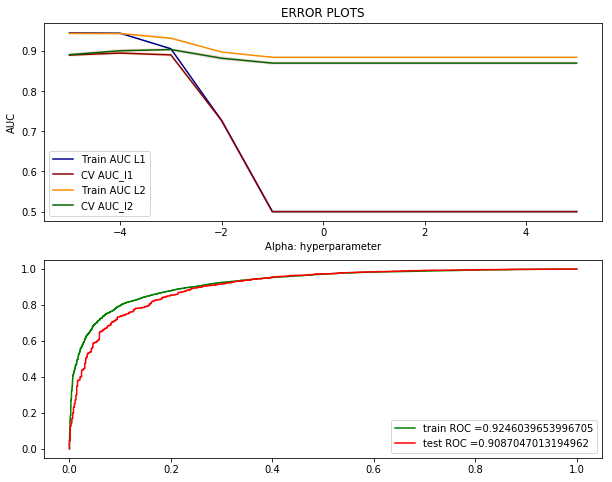

Train confusion matrix: 
[[ 2396   363]
 [ 2277 11002]]

Test confusion matrix: 
[[ 516  110]
 [ 576 2808]]

Test Sensitivity or True Positive Rate: 0.47
Test Specificity or False Negative Rate: 0.96
Top 10 positive features: 

                coef
features           
great      3.397903
best       2.548165
love       2.445061
good       2.097402
perfect    2.088400
delicious  2.062337
loves      1.842996
nice       1.823710
excellent  1.648658
easy       1.624849


Top 10 negative features: 

                   coef
features              
not          -3.196791
disappointed -2.301905
money        -1.825494
bad          -1.497798
product      -1.426770
not buy      -1.355534
away         -1.286265
ingredients  -1.202698
guess        -1.183442
box          -1.135571


In [38]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
alpha_list = (list(np.power(([10]*len(powers)), powers)))
estimator= SGDClassifier(loss='hinge', class_weight= 'balanced')
param_distributions={
    'alpha' : alpha_list,
    'penalty' : ['l1', 'l2']
    
}

train= final_tf_idf
test= final_tf_idf_test
rand= RSearchCV(estimator, param_distributions, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cross, verbose=2, random_state=5, return_train_score=True)
grid= rand.fit(train, y_train)
best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_
#print(rand.cv_results_[] )
print('best score : ', best_score)
print('best parameter : ', best_param)
train_auc_l1= grid.cv_results_['mean_train_score'][0::2]
train_auc_std_l1= grid.cv_results_['std_train_score'][0::2]
cv_auc_l1 = grid.cv_results_['mean_test_score'] [0::2]
cv_auc_std_l1= grid.cv_results_['std_test_score'][0::2]

train_auc_l2= grid.cv_results_['mean_train_score'][1::2]
train_auc_std_l2= grid.cv_results_['std_train_score'][1::2]
cv_auc_l2 = grid.cv_results_['mean_test_score'] [1::2]
cv_auc_std_l2= grid.cv_results_['std_test_score'][1::2]


# Plotting train AUC
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(alpha_list), train_auc_l1, label='Train AUC L1', color='darkblue')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc_l1 - train_auc_std_l1, train_auc_l1 + train_auc_std_l1, alpha=0.2)

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc_l1, label='CV AUC_l1', color='darkred')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc_l1 - cv_auc_std_l1,cv_auc_l1 + cv_auc_std_l1, alpha=0.2)
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')

ax1.plot(np.log10(alpha_list), train_auc_l2, label='Train AUC L2', color='darkorange')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc_l2 - train_auc_std_l2, train_auc_l2 + train_auc_std_l2, alpha=0.2)

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc_l2, label='CV AUC_l2', color='darkgreen')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc_l2 - cv_auc_std_l2,cv_auc_l2 + cv_auc_std_l2, alpha=0.2)
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')

ax1.legend()

ax2 = fig.add_subplot(212)
score_roc_train = best_model.decision_function(train)
score_roc_test = best_model.decision_function(test)
#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()


plt.show()

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_TFIDF= grid.best_estimator_
AUC_TFIDF= grid.best_score_
CM_TFIDF= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))# Top Positive and Negative Features

best_model.fit(train, y_train)
features = count_vect.get_feature_names()
features_coef= pd.DataFrame()

#top= (features_coef.sort_index(ascending=False).head(10))
#print(top.values)
features_coef['features']= features
features_coef['coef']= best_model.coef_[0]
features_coef= features_coef.sort_values(by='coef', ascending=False)
features_coef= features_coef.set_index('features')
#print(best_model.feature_log_prob_[0])
print('Top 10 positive features: \n\n', features_coef.head(10))
features_coef= features_coef.iloc[::-1]

print('\n\nTop 10 negative features: \n\n', features_coef.head(10))

In [39]:
# Top Positive and Negative Features

best_model.fit(train, y_train)
features = count_vect.get_feature_names()
features_coef= pd.DataFrame()

#top= (features_coef.sort_index(ascending=False).head(10))
#print(top.values)
features_coef['features']= features
features_coef['coef']= best_model.coef_[0]
features_coef= features_coef.sort_values(by='coef', ascending=False)
features_coef= features_coef.set_index('features')
#print(best_model.feature_log_prob_[0])
print('Top 10 positive features: \n\n', features_coef.head(10))
features_coef= features_coef.iloc[::-1]

print('\n\nTop 10 negative features: \n\n', features_coef.head(10))

Top 10 positive features: 

                coef
features           
great      3.396262
best       2.535374
love       2.448124
good       2.096751
perfect    2.081643
delicious  2.061142
loves      1.842186
nice       1.816691
excellent  1.628658
easy       1.615913


Top 10 negative features: 

                   coef
features              
not          -3.222160
disappointed -2.318130
money        -1.840230
bad          -1.488232
product      -1.453708
not buy      -1.367289
away         -1.281242
ingredients  -1.201945
box          -1.172174
guess        -1.158025


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

Fitting 2 folds for each of 22 candidates, totalling 44 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:   30.1s finished


best score :  0.8840221444290551
best parameter :  {'penalty': 'l1', 'alpha': 0.0001}


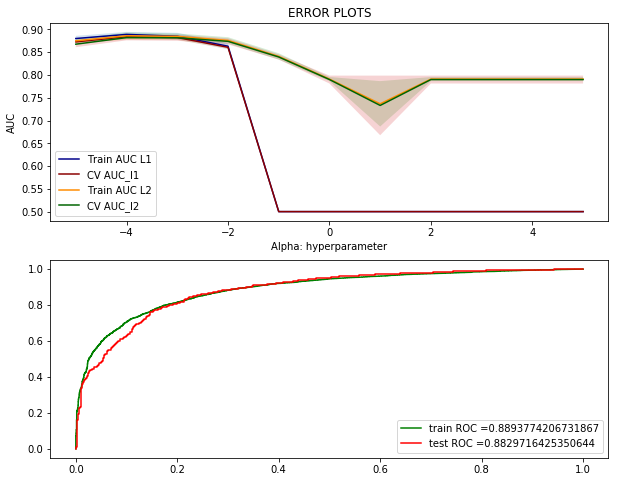

Train confusion matrix: 
[[2481  278]
 [3876 9403]]

Test confusion matrix: 
[[ 540   86]
 [ 937 2447]]

Test Sensitivity or True Positive Rate: 0.37
Test Specificity or False Negative Rate: 0.97


In [40]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
alpha_list = (list(np.power(([10]*len(powers)), powers)))
estimator= SGDClassifier(loss='hinge', class_weight= 'balanced')
param_distributions={
    'alpha' : alpha_list,
    'penalty' : ['l1', 'l2']
    
}

train= sent_vectors
test= sent_vectors_test
rand= RSearchCV(estimator, param_distributions, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cross, verbose=2, random_state=5, return_train_score=True)
grid= rand.fit(train, y_train)
best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_
#print(rand.cv_results_[] )
print('best score : ', best_score)
print('best parameter : ', best_param)
train_auc_l1= grid.cv_results_['mean_train_score'][0::2]
train_auc_std_l1= grid.cv_results_['std_train_score'][0::2]
cv_auc_l1 = grid.cv_results_['mean_test_score'] [0::2]
cv_auc_std_l1= grid.cv_results_['std_test_score'][0::2]

train_auc_l2= grid.cv_results_['mean_train_score'][1::2]
train_auc_std_l2= grid.cv_results_['std_train_score'][1::2]
cv_auc_l2 = grid.cv_results_['mean_test_score'] [1::2]
cv_auc_std_l2= grid.cv_results_['std_test_score'][1::2]


# Plotting train AUC
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(alpha_list), train_auc_l1, label='Train AUC L1', color='darkblue')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc_l1 - train_auc_std_l1, train_auc_l1 + train_auc_std_l1, alpha=0.2)

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc_l1, label='CV AUC_l1', color='darkred')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc_l1 - cv_auc_std_l1,cv_auc_l1 + cv_auc_std_l1, alpha=0.2)
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')

ax1.plot(np.log10(alpha_list), train_auc_l2, label='Train AUC L2', color='darkorange')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc_l2 - train_auc_std_l2, train_auc_l2 + train_auc_std_l2, alpha=0.2)

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc_l2, label='CV AUC_l2', color='darkgreen')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc_l2 - cv_auc_std_l2,cv_auc_l2 + cv_auc_std_l2, alpha=0.2)
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')

ax1.legend()

ax2 = fig.add_subplot(212)
score_roc_train = best_model.decision_function(train)
score_roc_test = best_model.decision_function(test)
#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()


plt.show()

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_AVG_W2V= grid.best_estimator_
AUC_AVG_W2V= grid.best_score_
CM_AVG_W2V= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 2 folds for each of 22 candidates, totalling 44 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:   29.7s finished


best score :  0.8447391869139584
best parameter :  {'penalty': 'l1', 'alpha': 0.001}


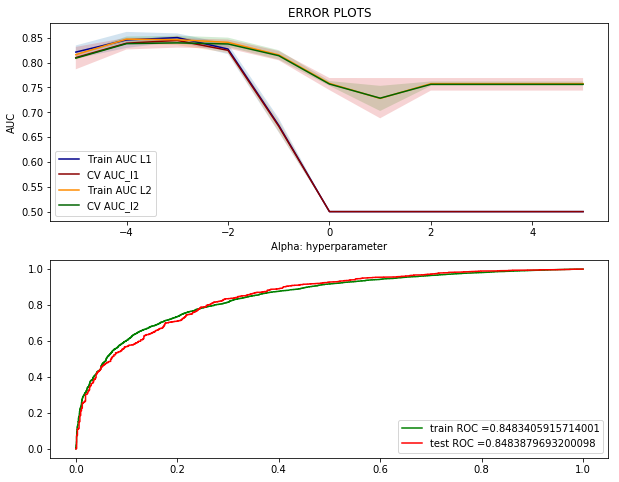

Train confusion matrix: 
[[2257  502]
 [3757 9522]]

Test confusion matrix: 
[[ 494  132]
 [ 936 2448]]

Test Sensitivity or True Positive Rate: 0.35
Test Specificity or False Negative Rate: 0.95


In [41]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
alpha_list = (list(np.power(([10]*len(powers)), powers)))
estimator= SGDClassifier(loss='hinge', class_weight= 'balanced')
param_distributions={
    'alpha' : alpha_list,
    'penalty' : ['l1', 'l2']
    
}

train= tfidf_sent_vectors
test= tfidf_sent_vectors_test
rand= RSearchCV(estimator, param_distributions, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cross, verbose=2, random_state=5, return_train_score=True)
grid= rand.fit(train, y_train)
best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_
#print(rand.cv_results_[] )
print('best score : ', best_score)
print('best parameter : ', best_param)
train_auc_l1= grid.cv_results_['mean_train_score'][0::2]
train_auc_std_l1= grid.cv_results_['std_train_score'][0::2]
cv_auc_l1 = grid.cv_results_['mean_test_score'] [0::2]
cv_auc_std_l1= grid.cv_results_['std_test_score'][0::2]

train_auc_l2= grid.cv_results_['mean_train_score'][1::2]
train_auc_std_l2= grid.cv_results_['std_train_score'][1::2]
cv_auc_l2 = grid.cv_results_['mean_test_score'] [1::2]
cv_auc_std_l2= grid.cv_results_['std_test_score'][1::2]


# Plotting train AUC
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(alpha_list), train_auc_l1, label='Train AUC L1', color='darkblue')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc_l1 - train_auc_std_l1, train_auc_l1 + train_auc_std_l1, alpha=0.2)

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc_l1, label='CV AUC_l1', color='darkred')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc_l1 - cv_auc_std_l1,cv_auc_l1 + cv_auc_std_l1, alpha=0.2)
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')

ax1.plot(np.log10(alpha_list), train_auc_l2, label='Train AUC L2', color='darkorange')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc_l2 - train_auc_std_l2, train_auc_l2 + train_auc_std_l2, alpha=0.2)

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc_l2, label='CV AUC_l2', color='darkgreen')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc_l2 - cv_auc_std_l2,cv_auc_l2 + cv_auc_std_l2, alpha=0.2)
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')

ax1.legend()

ax2 = fig.add_subplot(212)
score_roc_train = best_model.decision_function(train)
score_roc_test = best_model.decision_function(test)
#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_TFIDF_W2V= grid.best_estimator_
AUC_TFIDF_W2V= grid.best_score_
CM_TFIDF_W2V= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

## [5.2] RBF SVM

x_drop, rbf_train, y_drop, y_rbf_train= train_test_split(preprocessed_reviews, final['Score'], test_size= 0.01, shuffle= False, stratify= None) #0.56 for 40k points
print(len(rbf_train))
print(preprocessed_reviews[-1])
print(rbf_train[-1])

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV as RSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.utils import class_weight

cross= 2

x_drop, rbf_train, y_drop, y_rbf_train= train_test_split(preprocessed_reviews, final['Score'], test_size= 0.19, shuffle= False, stratify= None) #0.38 for 40k points 
print(len(rbf_train)) 
print(preprocessed_reviews[-1]) 
print(rbf_train[-1])

20048
healthy dog food good digestion also good small puppies dog eats required amount every feeding
healthy dog food good digestion also good small puppies dog eats required amount every feeding


In [0]:
### All Vectorization on 20k points to speed up.


#BoW
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(rbf_train, y_rbf_train, test_size= 0.20, shuffle= False, stratify= None)

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features= 500) #in scikit-learn
count_vect.fit_transform(x_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(x_train)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


final_counts_test= count_vect.transform(x_test)


tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features= 500)
tf_idf_vect.fit(x_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(x_train)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

final_tf_idf_test = tf_idf_vect.transform(x_test)

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    #print(w2v_model.wv.most_similar('great'))
    print('='*50)
    #print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))    
    
    
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features= 500)
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec


i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
    
    
    
    
i=0
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1    



some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almond', 'almost', 'already', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (16038, 500)
the number of unique words  500
some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almond', 'almost', 'already', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (16038, 500)
the number of unique words including both unigrams and bigrams  500
number of words that occured minimum 5 times  7645
sample words  ['product', 'not', 'live', 'packaging', 'promotion', 'real', 'maple', 'syrup', 'greatly', 'disappointed', 'based', 'amazon', 'led', 'believe', 'wrong', 'buy', 'type', 'dumped', 'onto', 'buying', 'public', 'exactly', 'nation', 'shape', 'date', 'coffee', 'friends', 'converted', 'drinking', 'various', 'types', 'green', 'teas', 'withs


16038
50



4010
50


### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

Fitting 2 folds for each of 11 candidates, totalling 22 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:  3.1min finished


best score :  0.8934014519429008
best parameter :  {'C': 10.0}


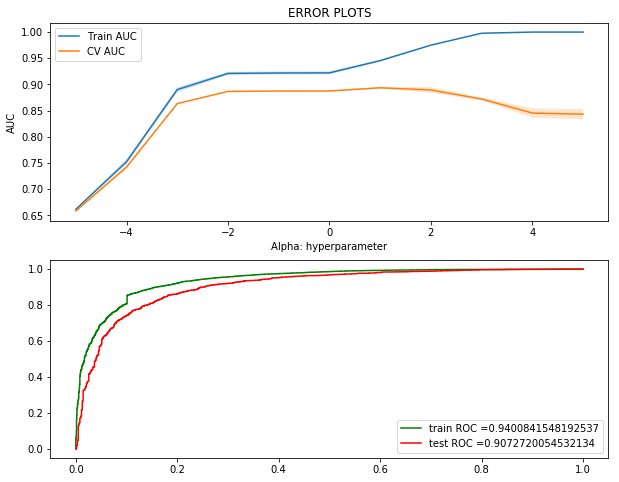

Train confusion matrix: 
[[ 1497  1262]
 [  239 13040]]

Test confusion matrix: 
[[ 286  340]
 [  91 3293]]

Test Sensitivity or True Positive Rate: 0.76
Test Specificity or False Negative Rate: 0.91


In [0]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
alpha_list = (list(np.power(([10]*len(powers)), powers)))
estimator= SVC(kernel='rbf')
param_distributions={
    'C' : alpha_list,   
}

train= final_counts
test= final_counts_test
rand= RSearchCV(estimator, param_distributions, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cross, verbose=2, random_state=5, return_train_score=True)
grid= rand.fit(train, y_train)
best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_
#print(rand.cv_results_[] )
print('best score : ', best_score)
print('best parameter : ', best_param)
train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score']
cv_auc_std= grid.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(alpha_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2)

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2)
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')

ax1.legend()

ax2 = fig.add_subplot(212)
score_roc_train = best_model.decision_function(train)
score_roc_test = best_model.decision_function(test)
#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()


plt.show()

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_BOW_RBF= grid.best_estimator_
AUC_BOW_RBF= grid.best_score_
CM_BOW_RBF= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

Fitting 2 folds for each of 11 candidates, totalling 22 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:  3.5min finished


best score :  0.9014891206319157
best parameter :  {'C': 100.0}


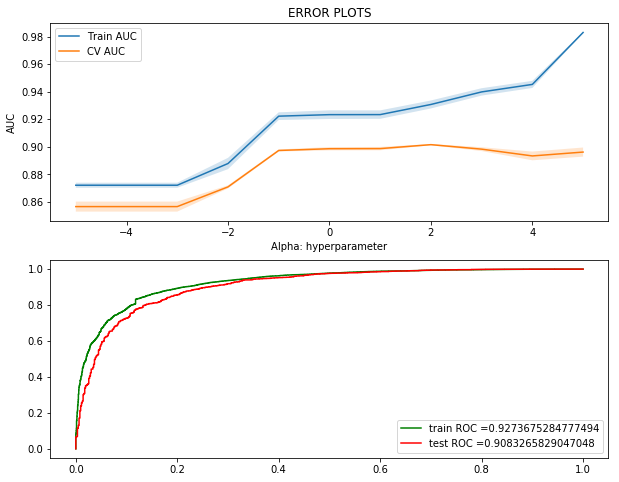

Train confusion matrix: 
[[ 1309  1450]
 [  260 13019]]

Test confusion matrix: 
[[ 276  350]
 [  67 3317]]

Test Sensitivity or True Positive Rate: 0.80
Test Specificity or False Negative Rate: 0.90


In [0]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
alpha_list = (list(np.power(([10]*len(powers)), powers)))
estimator= SVC(kernel='rbf')
param_distributions={
    'C' : alpha_list,   
}

train= final_tf_idf
test= final_tf_idf_test
rand= RSearchCV(estimator, param_distributions, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cross, verbose=2, random_state=5, return_train_score=True)
grid= rand.fit(train, y_train)
best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_
#print(rand.cv_results_[] )
print('best score : ', best_score)
print('best parameter : ', best_param)
train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score']
cv_auc_std= grid.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(alpha_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2)

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2)
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')

ax1.legend()

ax2 = fig.add_subplot(212)
score_roc_train = best_model.decision_function(train)
score_roc_test = best_model.decision_function(test)
#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()


plt.show()

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_TFIDF_RBF= grid.best_estimator_
AUC_TFIDF_RBF= grid.best_score_
CM_TFIDF_RBF= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

Fitting 2 folds for each of 11 candidates, totalling 22 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:  7.3min finished


best score :  0.8909584012090552
best parameter :  {'C': 100.0}


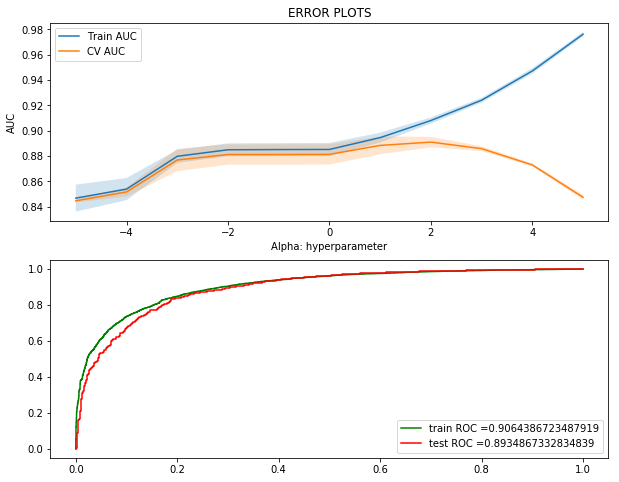

Train confusion matrix: 
[[ 1234  1525]
 [  380 12899]]

Test confusion matrix: 
[[ 276  350]
 [  84 3300]]

Test Sensitivity or True Positive Rate: 0.77
Test Specificity or False Negative Rate: 0.90


In [31]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
alpha_list = (list(np.power(([10]*len(powers)), powers)))
estimator= SVC(kernel='rbf')
param_distributions={
    'C' : alpha_list,   
}

train= sent_vectors
test= sent_vectors_test
rand= RSearchCV(estimator, param_distributions, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cross, verbose=2, random_state=5, return_train_score=True)
grid= rand.fit(train, y_train)
best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_
#print(rand.cv_results_[] )
print('best score : ', best_score)
print('best parameter : ', best_param)
train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score']
cv_auc_std= grid.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(alpha_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2)

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2)
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')

ax1.legend()

ax2 = fig.add_subplot(212)
score_roc_train = best_model.decision_function(train)
score_roc_test = best_model.decision_function(test)
#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()


plt.show()

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_AVGW2V_RBF= grid.best_estimator_
AUC_AVGW2V_RBF= grid.best_score_
CM_AVGW2V_RBF= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 2 folds for each of 11 candidates, totalling 22 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed: 10.1min finished


best score :  0.8503839993904487
best parameter :  {'C': 10.0}


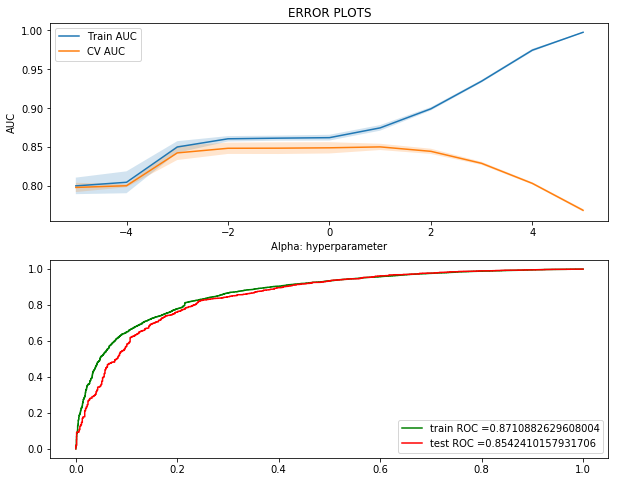

Train confusion matrix: 
[[  620  2139]
 [  180 13099]]

Test confusion matrix: 
[[ 154  472]
 [  48 3336]]

Test Sensitivity or True Positive Rate: 0.76
Test Specificity or False Negative Rate: 0.88


In [32]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
powers = list(np.arange(-5.0, 6.0, 1))
alpha_list = (list(np.power(([10]*len(powers)), powers)))
estimator= SVC(kernel='rbf')
param_distributions={
    'C' : alpha_list,   
}

train= tfidf_sent_vectors
test= tfidf_sent_vectors_test
rand= RSearchCV(estimator, param_distributions, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=cross, verbose=2, random_state=5, return_train_score=True)
grid= rand.fit(train, y_train)
best_score= grid.best_score_
best_param= grid.best_params_
best_model= grid.best_estimator_
#print(rand.cv_results_[] )
print('best score : ', best_score)
print('best parameter : ', best_param)
train_auc= grid.cv_results_['mean_train_score']
train_auc_std= grid.cv_results_['std_train_score']
cv_auc = grid.cv_results_['mean_test_score']
cv_auc_std= grid.cv_results_['std_test_score']

# Plotting train AUC
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax1.plot(np.log10(alpha_list), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), train_auc - train_auc_std, train_auc + train_auc_std, alpha=0.2)

# Plotting CV AUC
ax1.plot(np.log10(alpha_list), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
ax1.fill_between(np.log10(alpha_list), cv_auc - cv_auc_std,cv_auc + cv_auc_std, alpha=0.2)
ax1.set(title='ERROR PLOTS', xlabel='Alpha: hyperparameter', ylabel='AUC')

ax1.legend()

ax2 = fig.add_subplot(212)
score_roc_train = best_model.decision_function(train)
score_roc_test = best_model.decision_function(test)
#ROC curve on both train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

ax2.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)), color='green')
ax2.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)), color='red')
ax2.legend() 

plt.show()


plt.show()

TRCM= confusion_matrix(y_train, best_model.predict(train))
TECM= confusion_matrix(y_test, best_model.predict(test))
print("Train confusion matrix: ")
print(TRCM)
print("\nTest confusion matrix: ")
print(TECM)
EST_TFIDFW2V_RBF= grid.best_estimator_
AUC_TFIDFW2V_RBF= grid.best_score_
CM_TFIDFW2V_RBF= TECM
print('\nTest Sensitivity or True Positive Rate: {0:.2f}'.format(TECM[0][0]/(TECM[0][0]+TECM[1][0])))
print('Test Specificity or False Negative Rate: {0:.2f}'.format(TECM[1][1]/(TECM[0][1]+TECM[1][1])))

# [6] Conclusions

+------------+----------------+--------------------------------------------------------------------------------+--------------------+
| Vectorizer |     Model      |                                 Hyperparameter                                 |        AUC         |
+------------+----------------+--------------------------------------------------------------------------------+--------------------+
|    BOW     | SGD Classifier |       SGDClassifier(alpha=0.01, average=False, class_weight='balanced',        | 0.8936902924743952 |
|            |                |               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True, |                    |
|            |                |                    l1_ratio=0.15, learning_rate='optimal', loss='hinge',       |                    |
|            |                |                max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',   |                    |
|            |                |                   power_t=0.5,

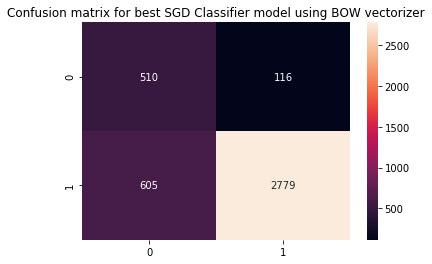

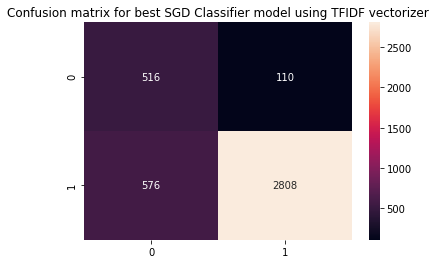

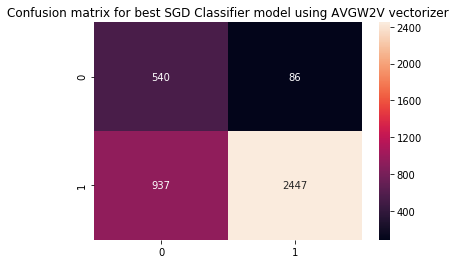

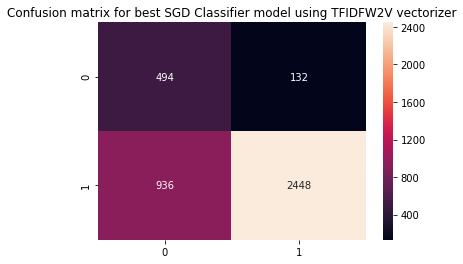

In [42]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
import seaborn as sns
x= PrettyTable(["Vectorizer", "Model", "Hyperparameter", "AUC"])
x.add_row(['BOW', 'SGD Classifier', EST_BOW, AUC_BOW])
x.add_row(['TFIDF', 'SGD Classifier', EST_TFIDF, AUC_TFIDF])
x.add_row(['AVG W2V', 'SGD Classifier', EST_AVG_W2V, AUC_AVG_W2V])
x.add_row(['TFIDF W2V', 'SGD Classifier', EST_TFIDF_W2V, AUC_TFIDF_W2V])
print(x)

ax= sns.heatmap(CM_BOW, annot=True, fmt="d")
ax.set_title('Confusion matrix for best SGD Classifier model using BOW vectorizer')
plt.show()

ax= sns.heatmap(CM_TFIDF, annot=True, fmt="d")
ax.set_title('Confusion matrix for best SGD Classifier model using TFIDF vectorizer')
plt.show()

ax= sns.heatmap(CM_AVG_W2V, annot=True, fmt="d")
ax.set_title('Confusion matrix for best SGD Classifier model using AVGW2V vectorizer')
plt.show()

ax= sns.heatmap(CM_TFIDF_W2V, annot=True, fmt="d")
ax.set_title('Confusion matrix for best SGD Classifier model using TFIDFW2V vectorizer')
plt.show()

+------------+----------------+-----------------------------------------------------------------------+--------------------+
| Vectorizer |     Model      |                             Hyperparameter                            |        AUC         |
+------------+----------------+-----------------------------------------------------------------------+--------------------+
|    BOW     | SVC Classifier |       SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,       | 0.8934014519429008 |
|            |                |     decision_function_shape='ovr', degree=3, gamma='auto_deprecated', |                    |
|            |                |      kernel='rbf', max_iter=-1, probability=False, random_state=None, |                    |
|            |                |                 shrinking=True, tol=0.001, verbose=False)             |                    |
|   TFIDF    | SVC Classifier |       SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,      | 0.9014891206319157 |


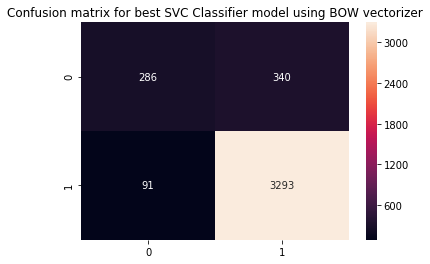

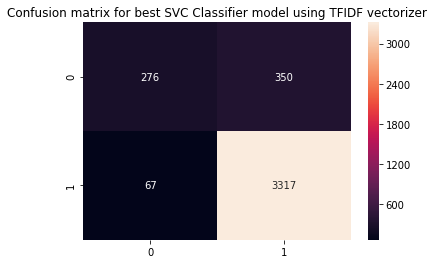

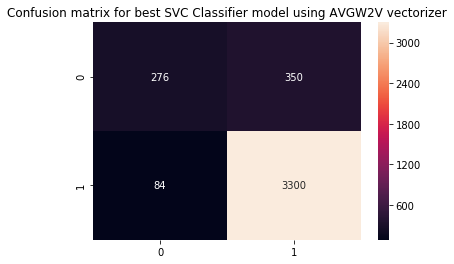

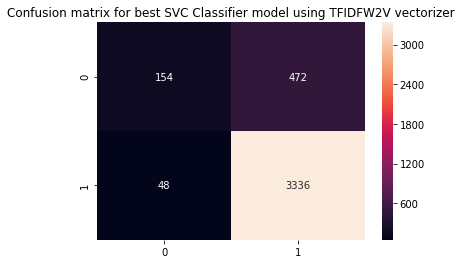

In [34]:
from prettytable import PrettyTable
import seaborn as sns

x= PrettyTable(["Vectorizer", "Model", "Hyperparameter", "AUC"])
x.add_row(['BOW', 'SVC Classifier', EST_BOW_RBF, AUC_BOW_RBF])
x.add_row(['TFIDF', 'SVC Classifier', EST_TFIDF_RBF, AUC_TFIDF_RBF])
x.add_row(['AVG W2V', 'SVC Classifier', EST_AVGW2V_RBF, AUC_AVGW2V_RBF])
x.add_row(['TFIDF W2V', 'SVC Classifier', EST_TFIDFW2V_RBF, AUC_TFIDFW2V_RBF])
print(x)

ax= sns.heatmap(CM_BOW_RBF, annot=True, fmt="d")
ax.set_title('Confusion matrix for best SVC Classifier model using BOW vectorizer')
plt.show()

ax= sns.heatmap(CM_TFIDF_RBF, annot=True, fmt="d")
ax.set_title('Confusion matrix for best SVC Classifier model using TFIDF vectorizer')
plt.show()

ax= sns.heatmap(CM_AVGW2V_RBF, annot=True, fmt="d")
ax.set_title('Confusion matrix for best SVC Classifier model using AVGW2V vectorizer')
plt.show()

ax= sns.heatmap(CM_TFIDFW2V_RBF, annot=True, fmt="d")
ax.set_title('Confusion matrix for best SVC Classifier model using TFIDFW2V vectorizer')
plt.show()